# CHANGES IN THE NOTEBOOK

1.   KERAS DATASET IS USED
2.   AUGMENTATION IS REMOVED
3.   MODEL IS  STILL DEFINED USING tf.nn BUT CHANGED A BIT 



# OBSERVATION MADE


1.   Kronecker product preconditioning training loss start increasing after some iterations



In [1]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY'
sys.path.append(base_dir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import preconditioned_stochastic_gradient_descent as psgd 
from tabulate import tabulate
import scipy.io

## Download MNIST Data

In [7]:
"""MNIST, classification"""
np.random.seed(0)

# Parameter Settings
batch_size = 128
num_f = 32  # number of features 

dtype = tf.float32

mnist = tf.contrib.learn.datasets.load_dataset('mnist')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-u

In [8]:
# Load the FashionMNIST dataset, scale the pixel values
(train_data, train_label0), (test_data, test_label0) = tf.keras.datasets.mnist.load_data()
train_data =train_data/255.
test_data = test_data/255.

train_data.shape, test_data.shape, train_label0.shape, test_label0.shape

train_data = train_data.astype("float32").reshape(-1, 28, 28, 1)
test_data = test_data.astype("float32").reshape(-1, 28, 28, 1)

#binarize the labels
train_label = np.zeros([60000, 10])
test_label = np.zeros([10000, 10])
train_label[np.arange(60000),  train_label0] = 1.0
test_label[np.arange(10000),  test_label0] = 1.0
print(train_label.shape)
print(test_label.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 10)
(10000, 10)


In [0]:
def get_batches():
    # generate 60000 numbers randomly without replacement
    rp = np.random.permutation(train_data.shape[0])
    x = -np.ones([batch_size, 28, 28, 1])
    
    # augumentation: randomly shifting image by +-2 pixels 
    for i in range(batch_size):
        x[i] = train_data[rp[i]]
    y = train_label[rp[0:batch_size]]
    return x, y

## Defining CNN model for training.
The model consists of 2 convolutional layers, 1 avgpool layer, 2 convolutional layers, 1 avg pool layer, 1 FC layer, 1 FC layer.

In [0]:
train_inputs = tf.placeholder(dtype, [batch_size, 28, 28, 1])
train_outputs = tf.placeholder(dtype, [batch_size, 10])
adam_step = tf.placeholder(tf.float32, shape = ())

In [0]:
# (hight, width, in_ch, out_ch) tensor --> (hight * width * in_ch, out_ch) matrix 
W1 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*1+1), size=[3*3*1+1, num_f]), dtype=dtype)
W2 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W3 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W4 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W5 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(4*4*num_f+1), size=[4*4*num_f+1, 10]), dtype=dtype)
Ws = [W1, W2, W3, W4, W5]

# we use the traditional tanh
def model(Ws, inputs):
    
    W1, W2, W3, W4, W5 = Ws
    w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    b1 = W1[-1]
    x1 = tf.tanh( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID') + b1 )
    
        
    w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    b2 = W2[-1]
    x2 = tf.tanh( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID') + b2 )
    
    x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    b3 = W3[-1]
    x3 = tf.tanh( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID') + b3 )
        
    w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    b4 = W4[-1]
    x4 = tf.tanh( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4 )
    
    x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

    batch_size = inputs.shape.as_list()[0]
    x4_flat = tf.reshape(x4, [batch_size, -1])
    ones = tf.ones([batch_size, 1], dtype=dtype)

    y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5)
    return y

## Define cross entropy as Training Loss function (Loss function) and Test Loss function

In [0]:
# cross entropy loss
def train_criterion(Ws):
    y = model(Ws, train_inputs)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_outputs, logits=y))

# classification error rate
def test_criterion(Ws):
    y = model(Ws, tf.constant(test_data, dtype=dtype))
    # return 1 - accuracy 
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=test_label, logits=y))
    # return 1.0 - tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.constant(mnist.test.labels, dtype=tf.int64)), dtype=dtype))

# SGD

train loss: 2.304683208465576; test loss: 2.2948954105377197; time:0.10655713081359863
train loss: 1.9655711666107187; test loss: 1.524965763092041; time:0.5696926116943359
train loss: 1.4244864064912943; test loss: 0.8610206246376038; time:1.0350205898284912
train loss: 0.9739652945592641; test loss: 0.6285374164581299; time:1.491619348526001
train loss: 0.7260614921734038; test loss: 0.5324500203132629; time:1.9290318489074707
train loss: 0.5965153013524592; test loss: 0.4763335883617401; time:2.3647491931915283
train loss: 0.5238244053160833; test loss: 0.43934550881385803; time:2.7978367805480957
train loss: 0.46497259687673254; test loss: 0.41180771589279175; time:3.2377822399139404
train loss: 0.4398622788528721; test loss: 0.3896717131137848; time:3.675987720489502
train loss: 0.4136368108645007; test loss: 0.3729063868522644; time:4.110223054885864
train loss: 0.398452140439431; test loss: 0.3580753803253174; time:4.552094459533691
train loss: 0.37526701816165353; test loss: 0.

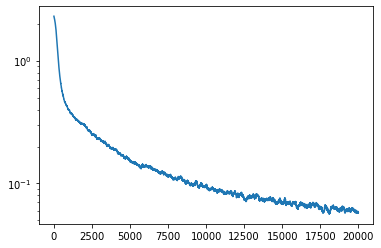

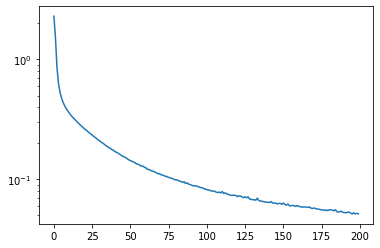

In [36]:
step_size = 0.01
grad_norm_clip_thr = 1e0 # may need gradients cliping for RNN training; otherwise, set it to an extremely large value  

with tf.Session() as sess:
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    test_loss = test_criterion(Ws)

    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _ = sess.run([train_loss, update_Ws],
                                  {train_inputs: _train_inputs, train_outputs: _train_outputs})     
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; time:{}'.format(TrainLoss[-1],TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

 
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/SGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ADAM

train loss: 2.3352465629577637; test loss: 2.6551129817962646; Time: 0.14309477806091309
train loss: 0.43977977655977; test loss: 0.175435870885849; Time: 0.6625518798828125
train loss: 0.24481300387861693; test loss: 0.11919240653514862; Time: 1.17319655418396
train loss: 0.15427791315865932; test loss: 0.06738575547933578; Time: 1.6825361251831055
train loss: 0.10355487771087832; test loss: 0.0659918487071991; Time: 2.1953954696655273
train loss: 0.07566036559999144; test loss: 0.0642981007695198; Time: 2.7100656032562256
train loss: 0.06851157782482833; test loss: 0.05162631720304489; Time: 3.2139291763305664
train loss: 0.061650010860064434; test loss: 0.055254168808460236; Time: 3.719801425933838
train loss: 0.0573754429574788; test loss: 0.044458430260419846; Time: 4.229202032089233
train loss: 0.045211603719029346; test loss: 0.04753115028142929; Time: 4.744556903839111
train loss: 0.0491375645129367; test loss: 0.04776385426521301; Time: 5.259451866149902
train loss: 0.04972052

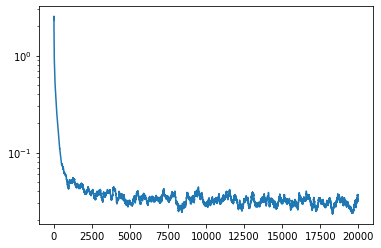

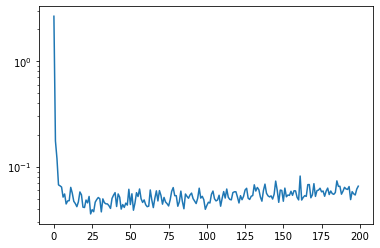

In [37]:
# Adam 
step_size = 0.005
beta1 = 0.9
beta2 = 0.999
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_moment = [beta1*m + (1.0 - beta1)*g for (m, g) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*v + (1.0 - beta2)*g*g for (v, g) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]
          
    new_Ws = [W - step_size*m/(tf.sqrt(v) + offset) for (W, m, v) in zip(Ws, new_grads_moment_hat, new_grads_vars_hat)]
  
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches()
     
        t = t + 1
        t0 = time.time()
        _train_loss, _update_Ws,_update_v,_update_m = sess.run([train_loss, update_Ws, update_grads_vars, update_grads_moment],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step:t})  
        
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# SGD with RMSprop

train loss: 2.298992156982422; test loss: 2.2612147331237793; Time: 0.15012407302856445
train loss: 0.8839079605370754; test loss: 0.4236064553260803; Time: 0.6260128021240234
train loss: 0.5552399047163636; test loss: 0.2972590923309326; Time: 1.0915765762329102
train loss: 0.37265480432094233; test loss: 0.22080476582050323; Time: 1.5596261024475098
train loss: 0.2692868422452034; test loss: 0.17313514649868011; Time: 2.0438108444213867
train loss: 0.20078042201321228; test loss: 0.15200209617614746; Time: 2.518726110458374
train loss: 0.16033499771461526; test loss: 0.11371289938688278; Time: 2.9844443798065186
train loss: 0.13495767683400725; test loss: 0.09480603039264679; Time: 3.455246925354004
train loss: 0.10947453304568469; test loss: 0.0850716307759285; Time: 3.917092800140381
train loss: 0.0997259785841818; test loss: 0.07446204870939255; Time: 4.390542507171631
train loss: 0.08668620978628257; test loss: 0.06943463534116745; Time: 4.863868236541748
train loss: 0.0829410990

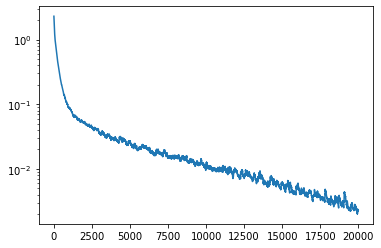

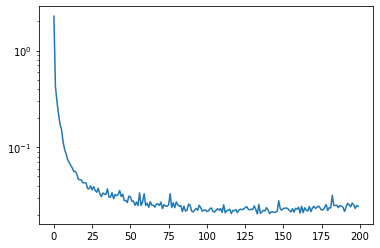

In [38]:
# RMSProp  
step_size = 0.0005
max_mu = 0.99
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for grads**2 estimation 
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_vars = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(grads_vars, grads)]
    new_Ws = [W - step_size*g/tf.sqrt(v + offset) for (W, g, v) in zip(Ws, grads, new_grads_vars)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_mu],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs})  
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/rmsprop.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# PSGD with Kronecker Product Preconditioning




train loss: 2.3104937076568604; test loss: 2.2782397270202637; Time: 6.359009027481079
train loss: 0.9753823692649602; test loss: 0.4022747576236725; Time: 7.62630820274353
train loss: 0.565260250672045; test loss: 0.24997578561306; Time: 8.89974045753479
train loss: 0.34149725999315317; test loss: 0.1615859568119049; Time: 10.185884475708008
train loss: 0.2155176317008885; test loss: 0.11508780717849731; Time: 11.474072933197021
train loss: 0.14942644199550698; test loss: 0.09209507703781128; Time: 12.755045890808105
train loss: 0.11567420233962582; test loss: 0.07694638520479202; Time: 14.022310256958008
train loss: 0.09821223764043262; test loss: 0.06656520068645477; Time: 15.288113832473755
train loss: 0.08097214296794653; test loss: 0.05827707052230835; Time: 16.557172775268555
train loss: 0.0708396774603184; test loss: 0.05198701098561287; Time: 17.83256506919861
train loss: 0.059786415416022774; test loss: 0.047591663897037506; Time: 19.11215829849243
train loss: 0.0572581448

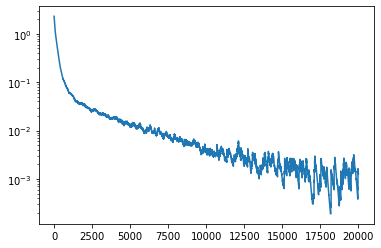

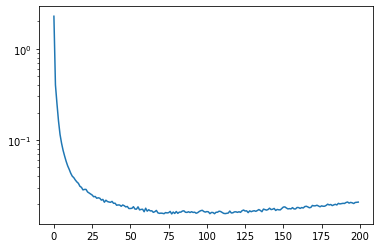

In [13]:
step_size = 0.05
# grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  
grad_norm_clip_thr = 1e0
step_size_adjust = 1.0
with tf.Session() as sess:   
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, hess_deltaw)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time': Time})

# PSGD with Kronecker Product Preconditioning (Approximated H*v product)

train loss: 2.309722900390625; test loss: 2.2685365676879883, time:0.19826292991638184
train loss: 0.9501525009393693; test loss: 0.39768311381340027, time:1.2419121265411377
train loss: 0.5596288419793708; test loss: 0.25511470437049866, time:2.295422315597534
train loss: 0.3410022760297242; test loss: 0.16419458389282227, time:3.336923599243164
train loss: 0.21750862023737896; test loss: 0.11607407033443451, time:4.382324695587158
train loss: 0.1471782307209017; test loss: 0.09128500521183014, time:5.41469144821167
train loss: 0.11519087907987743; test loss: 0.07508455961942673, time:6.445808172225952
train loss: 0.09238540630492172; test loss: 0.06508643925189972, time:7.485983848571777
train loss: 0.08054910196933637; test loss: 0.05737186223268509, time:8.507683992385864
train loss: 0.07218705750431202; test loss: 0.05193423479795456, time:9.545137882232666
train loss: 0.059749918186497906; test loss: 0.04664847254753113, time:10.575453996658325
train loss: 0.05549687210912416; te

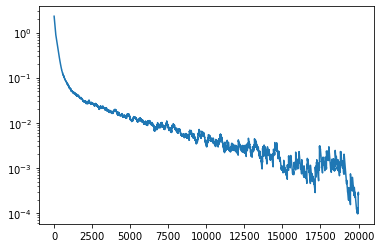

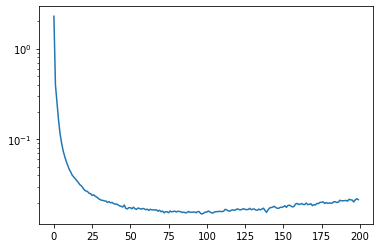

In [25]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Kronecker Product + ADAM

train loss: 2.2851853370666504; test loss: 2.2737510204315186, time:0.2468869686126709
train loss: 0.9582022655397653; test loss: 0.33370545506477356, time:1.350677490234375
train loss: 0.4951597908076991; test loss: 0.15625455975532532, time:2.444673538208008
train loss: 0.2627954173990737; test loss: 0.09657753258943558, time:3.533614158630371
train loss: 0.15408226078879983; test loss: 0.0686764121055603, time:4.631410360336304
train loss: 0.09908091475733294; test loss: 0.05690261349081993, time:5.720864534378052
train loss: 0.07244458345859632; test loss: 0.048543233424425125, time:6.798035621643066
train loss: 0.05709798111131309; test loss: 0.04213972017168999, time:7.895665168762207
train loss: 0.04985543376774029; test loss: 0.03748830407857895, time:8.9751296043396
train loss: 0.04449747252102865; test loss: 0.03518839552998543, time:10.07452917098999
train loss: 0.039231297803705385; test loss: 0.03181769698858261, time:11.187573194503784
train loss: 0.03648251299060093; tes

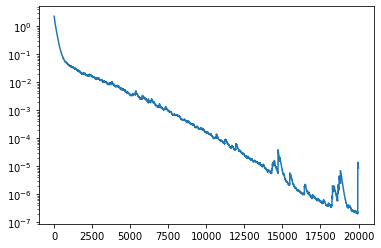

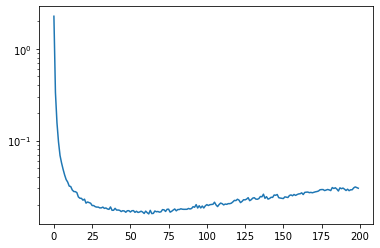

In [26]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, adam_grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _, _,_,_ = sess.run([train_loss, update_Ws, update_Qs,update_grads_moment, update_grads_vars],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Comparison of All above second order approximations

In [0]:
sgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/SGD.mat')
adam = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/adam.mat')
adam_kron = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_adam.mat')
rmsprop = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/rmsprop.mat')
kron_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond.mat')
kron_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST_COPY/results1/kron_precond_approx.mat')


In [0]:
sgd_time = sgd.get('Time').reshape(20000,)
adam_time = adam.get('Time').reshape(20000,)
rmsprop_time = rmsprop.get('Time').reshape(20000,)
kron_time =  kron_precond.get('Time').reshape(20000,)
kron_approx_time = kron_precond_approx.get('Time').reshape(20000,)
adam_kron_time = adam_kron.get('Time').reshape(20000,)


In [0]:
sgd_TrainLoss = sgd.get('TrainLoss').reshape(20000,)
adam_TrainLoss = adam.get('TrainLoss').reshape(20000,)
rmsprop_TrainLoss = rmsprop.get('TrainLoss').reshape(20000,)
kron_TrainLoss =  kron_precond.get('TrainLoss').reshape(20000,)
kron_approx_TrainLoss = kron_precond_approx.get('TrainLoss').reshape(20000,)
adam_kron_TrainLoss = adam_kron.get('TrainLoss').reshape(20000,)

In [0]:
sgd_TestLoss = sgd.get('TestLoss').reshape(200,)
adam_TestLoss = adam.get('TestLoss').reshape(200,)
rmsprop_TestLoss = rmsprop.get('TestLoss').reshape(200,)
kron_TestLoss =  kron_precond.get('TestLoss').reshape(200,)
kron_approx_TestLoss = kron_precond_approx.get('TestLoss').reshape(200,)
adam_kron_TestLoss = adam_kron.get('TestLoss').reshape(200,)


In [43]:
optimizers = ['SGD','adam', 'RMSprop', 'kron', 'kron_approx', 'hybrid_ADAMKRON']
training_time = [np.sum(sgd_time),np.sum(adam_time), np.sum(rmsprop_time), np.sum(kron_time),
                 np.sum(kron_approx_time),np.sum(adam_kron_time)]
print(tabulate(zip(optimizers, training_time),headers = ['optimizers','time (sec)']))

optimizers         time (sec)
---------------  ------------
SGD                   88.2568
adam                 100.872
RMSprop               94.6009
kron                 258.591
kron_approx          207.691
hybrid_ADAMKRON      218.217


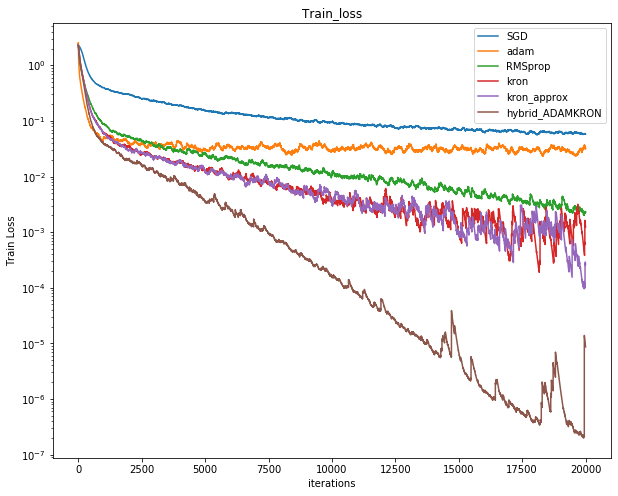

In [44]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TrainLoss)
plt.semilogy(adam_TrainLoss)
plt.semilogy(rmsprop_TrainLoss)
plt.semilogy(kron_TrainLoss)
plt.semilogy(kron_approx_TrainLoss)
plt.semilogy(adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('iterations')
plt.ylabel('Train Loss')
plt.legend(optimizers)

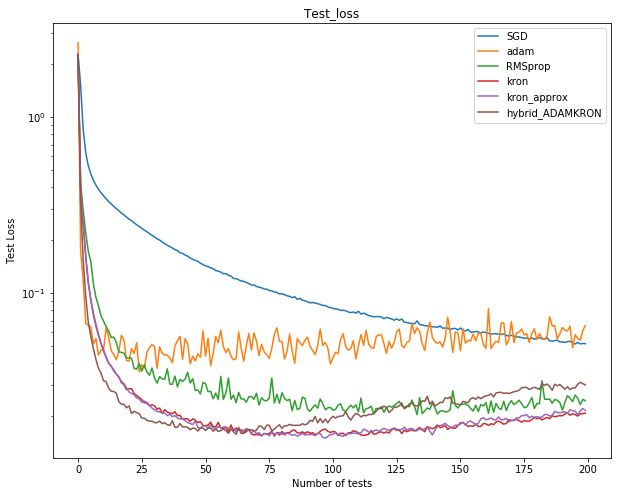

In [45]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TestLoss)
plt.semilogy(adam_TestLoss)
plt.semilogy(rmsprop_TestLoss)
plt.semilogy(kron_TestLoss)
plt.semilogy(kron_approx_TestLoss)
plt.semilogy(adam_kron_TestLoss)

plt.title('Test_loss')
plt.xlabel('Number of tests')
plt.ylabel('Test Loss')
plt.legend(optimizers)


In [0]:
sgd_t = np.cumsum(sgd_time)
adam_t =  np.cumsum(adam_time)
rmsprop_t = np.cumsum(rmsprop_time)
kron_t =  np.cumsum(kron_time)
kron_approx_t = np.cumsum(kron_approx_time)
adam_kron_t =  np.cumsum(adam_kron_time)

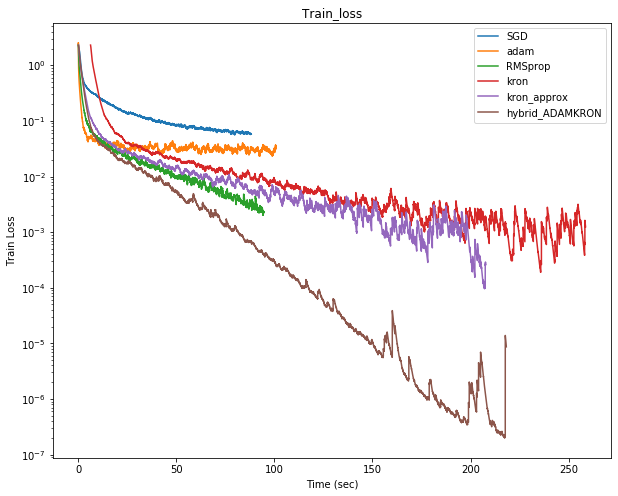

In [47]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_t,sgd_TrainLoss)
plt.semilogy(adam_t,adam_TrainLoss)
plt.semilogy(rmsprop_t,rmsprop_TrainLoss)
plt.semilogy(kron_t, kron_TrainLoss)
plt.semilogy(kron_approx_t, kron_approx_TrainLoss)
plt.semilogy(adam_kron_t,adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('Time (sec)')
plt.ylabel('Train Loss')
plt.legend(optimizers)
# plt.ylim([0,0.5])